In [1]:
import pandas as pd
import numpy as np
import re
data = pd.read_csv("properati.csv")

## Patrones -> Precio

In [2]:
# Precios inmueble

# detecto el precio (antecedido por usd y NO precedido por m2)

patron_precio_inm = '(usd|u\$d|u\$s|us\$|dolares) ?(\d{2,}(\,|\.)\d{0,3}\.?\d{0,3}|(\d{2,}(\,|\.)\d{0,3}\,?\.?\d{0,3}\,?\.?\d{0,3})) ?(?!(.*m2|.*mc|.*metros))'
regex_precio_inm = re.compile(patron_precio_inm, flags = re.IGNORECASE)

# formateo el precio (00.000.000 / 00.000 -> conjunto de tres cifras)

patron_precio_inm_2 = '(\d\d\d?\.)(\d\d\d\.)?(\d\d\d)'
regex_precio_inm_2 = re.compile(patron_precio_inm_2, flags = re.IGNORECASE)

### Búsqueda de Precios

#### Precios en descripción

In [3]:
# precios en descripción

precios_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else regex_precio_inm.search(x))
precios_descripcion = precios_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(2))

print('Macheos encontrados de precios en descripción:',precios_descripcion_macheo.notnull().sum())
print('Ejemplo:',precios_descripcion.iloc[55245])
precios_descripcion.isnull().value_counts()

Macheos encontrados de precios en descripción: 7034
Ejemplo: 750.000132


True     114186
False      7034
Name: description, dtype: int64

In [4]:
# precios formateados con regex

precios_descripcion_formateo_match = precios_descripcion\
                    .apply(lambda x: x if x is None or x is np.NaN else regex_precio_inm_2.search(x))

precios_descripcion_formateado = precios_descripcion_formateo_match\
                    .apply(lambda x: np.NaN if x is None or x is np.NaN else x.group()\
                        .replace(',','')\
                        .replace('.',''))\
                    .astype(float)

precios_descripcion_formateado.iloc[55245], precios_descripcion_formateado.notnull().sum()

(750000.0, 6778)

In [5]:
# formateo con condicional (mayores a cinco cifras y menores a nueve cifras)

precios_descripcion_filtado = precios_descripcion_formateado.apply(lambda x: x if x > 20000 and x < 30000000 else np.NaN)

print('Macheos de precios filtrados en titulo:', precios_descripcion_filtado.notnull().sum())

precios_descripcion_filtado.sort_values(ascending=False).head(10), precios_descripcion_filtado.notnull().sum()

Macheos de precios filtrados en titulo: 5853


(91468     25000000.0
 91229     14000000.0
 74066       993140.0
 73965       985320.0
 113972      980000.0
 74032       961860.0
 73927       954040.0
 71653       950000.0
 71409       950000.0
 73979       946220.0
 Name: description, dtype: float64,
 5853)

In [6]:
precios_descripcion_filtado.iloc[55245]

750000.0

#### Precios en título

In [7]:
# precios en descripción

precios_tit_macheo = data.title.apply(lambda x: x if x is np.NaN else regex_precio_inm.search(x))
precios_tit = precios_tit_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(2))

print('Macheos encontrados de precios en descripción:',precios_tit_macheo.notnull().sum())
print('Ejemplo:',precios_tit.iloc[1937])
precios_tit.isnull().value_counts()

Macheos encontrados de precios en descripción: 6592
Ejemplo: 123.456.789


True     114628
False      6592
Name: title, dtype: int64

In [8]:
# formateos con regex

precios_tit_formateo_match = precios_tit\
                    .apply(lambda x: x if x is None or x is np.NaN else regex_precio_inm_2.search(x))

precios_tit_formateado = precios_tit_formateo_match\
                    .apply(lambda x: np.NaN if x is None or x is np.NaN else x.group()\
                        .replace(',','')\
                        .replace('.',''))\
                    .astype(float)

# el siguiente nro debe ser filtrado
precios_tit_formateado.iloc[1937], precios_tit_formateado.notnull().sum()

(123456789.0, 6581)

In [9]:
# formateo con condicional (mayores a cinco cifras y menores a nueve cifras)

precios_tit_filtado = precios_tit_formateado.apply(lambda x: x if x > 20000 and x < 30000000 else np.NaN)

print('Macheos de precios filtrados en titulo:', precios_tit_filtado.notnull().sum())

precios_tit_filtado.sort_values(ascending=False).head(10)

Macheos de precios filtrados en titulo: 6574


34638    14000000.0
2082     11800000.0
525      11000000.0
8303       999999.0
5082       998000.0
17486      990000.0
9858       990000.0
11673      990000.0
21401      990000.0
21474      980000.0
Name: title, dtype: float64

### Revision

In [10]:
data.title.iloc[34638]

'Casa 2079m² en Del Libertador, Av. 2200, Vicente López, Olivos, por U$S 14.000.000'

In [11]:
data.description.iloc[91468]

'Casa con Agua Corriente, Córdoba, Punilla, por U$S 25.000.000'

### Fusión

In [12]:
precios_descripcion_filtado.notnull().sum()

5853

In [13]:
precios_tit_filtado.notnull().sum()

6574

In [14]:
data.price_aprox_usd.notnull().sum()

100810

#### Price + Precios de descripción

In [15]:
print('precios vacíos en columna price:',data.price_aprox_usd.isnull().sum())
print('precios a rellenar en columna price desde description:', precios_descripcion_filtado.loc[data.price_aprox_usd.isnull()].notnull().sum())

# imputacion de valores extraídos de desc
#data['price_desc'] = data['price_aprox_usd']
#data['price_desc'].loc[data.price_aprox_usd.isnull()] = precios_descripcion_filtado.loc[data.price_aprox_usd.isnull()]

print('precios vacios tras relleno con precios de desc:',data.price_desc.isnull().sum(),'\n20410 -','424 =',20410 - 424)

precios vacíos en columna price: 20410
precios a rellenar en columna price desde description: 424


AttributeError: 'DataFrame' object has no attribute 'price_desc'

#### Price + Precios de titulo

In [ ]:
print('precios vacíos en columna price:',data.price_aprox_usd.isnull().sum())
print('precios a rellenar en columna price desde title:', precios_tit_filtado.loc[data.price_aprox_usd.isnull()].notnull().sum())

# imputacion de valores extraídos de tit
#data['price_tit'] = data['price_aprox_usd']
data['price_tit'].loc[data.price_aprox_usd.isnull()] = precios_tit_filtado.loc[data.price_aprox_usd.isnull()]

print('precios vacios tras relleno con precios de tit:',data.price_tit.isnull().sum(),'\n20410 -','2383 =',20410 - 2383)

### Patrones -> Cochera

In [21]:
# Cochera
patron_cochera = '(?<!sin )(?<!no incluye )(?<!no posee )cochera(?! no incluye)(?! no incluida)'
regex_cochera = re.compile(patron_cochera, flags = re.IGNORECASE)

#### Cochera en descripción

In [22]:
cochera_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else regex_cochera.search(x))
cochera_descripcion = cochera_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group())

print('Macheos encontrados de cochera en descripción:',cochera_descripcion_macheo.notnull().sum())
print('Ejemplo:',cochera_descripcion.iloc[55245])
cochera_descripcion.notnull().value_counts()

Macheos encontrados de cochera en descripción: 42158
Ejemplo: Cochera


False    79062
True     42158
Name: description, dtype: int64

#### Cochera en título

In [23]:
cochera_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else regex_cochera.search(x))
cochera_titulo = cochera_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group())

print('Macheos encontrados de cochera en título:',cochera_titulo_macheo.notnull().sum())
print('Ejemplo:',cochera_titulo.iloc[114])
cochera_titulo.notnull().value_counts()

Macheos encontrados de cochera en título: 5985
Ejemplo: Cochera


False    115235
True       5985
Name: title, dtype: int64

In [24]:
data.title.iloc[114]

'Departamento 75m² con Cochera en Don Bosco 200, Bs.As. G.B.A. Zona Norte, San Isidro, por U$S 175.000'

In [25]:
data.description.iloc[55245]

'Bv. Rosario Vera Peñaloza y esq. Julieta LanteriZencity Un multicomplejo situado a la altura del Dique 1 de Puerto Madero. Cuenta con  amenities: desde Microcine, SPA, Sauna e Hidromasaje, SUM, varias piscinas y Solarium; hasta una Plaza Central de uso privado. Además: Bar Chill Out, Putting Green, Juegos para niños, Vestuarios, Laundry. Piscina Climatizada, Piscina de natación, Gimnasio, Seguridad 24hs. y un Business Center, Zencity Kids,  Departamento  Precio Venta  U$S 750.000132m² Superficie total125m² Superficie cubierta3 Ambientes2 Dormitorios3 Baños1 Toilette1 Cochera. '

In [26]:
data['cochera'] = cochera_descripcion.notnull()

data['cochera'].sum(), cochera_descripcion.notnull().sum()

(42158, 42158)

In [27]:
data['cochera'].loc[cochera_descripcion.isnull()] = cochera_titulo.notnull()

C:\Users\Foolface\.conda\envs\dh\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
data['cochera'].loc[data.property_type == 'house'].sum()

11726

### Patrones -> Pileta

In [29]:
pile_pat = 'piscina|pileta(?! de baño)(?! de cocina)'
pile_reg = re.compile(pile_pat, flags = re.IGNORECASE)

#### Piscina/pileta en Descripción

In [30]:
pile_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else pile_reg.search(x))
pile_descripcion = pile_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de piletas en descripción:',pile_descripcion_macheo.notnull().sum())
print('Ejemplo:',pile_descripcion.iloc[22])
pile_descripcion.notnull().value_counts()

Macheos de piletas en descripción: 32733
Ejemplo: Piscina


False    88487
True     32733
Name: description, dtype: int64

In [31]:
data.loc[pile_descripcion_macheo.notnull(),].index

Int64Index([     7,      8,     13,     14,     18,     22,     23,     30,
                36,     38,
            ...
            121144, 121154, 121155, 121156, 121157, 121211, 121212, 121213,
            121215, 121216],
           dtype='int64', length=32733)

In [32]:
data.description.iloc[121212]

'ESPECTACULAR CASA ESTILO RACIONALISTA EN CALLE CORTADA!!! TIENE UNA RENTA ACTIVA HASTA OCTUBRE DE 2017P.B: Espectacular hall de entrada con triple altura - Toilette - Gran living apaisado con chimenea - Comedor separado (5 x 4) - Escritorio - (todo con pisos de pinotea) - Buena cocina con comedor diario - 1 dormitorio con baño completo - dependencias de servicio con baño P.A.: Espectacular Family - 4 dormitorios (todos con pisos de madera grapia misionera): Ppal en suite (7 x 4) con vestidor y baño completo balcón terraza con vista al jardín + otra suite + otro baño.Excelente jardín con pileta - Parrilla - Galería - Calefacción central por radiadores'

#### Piscina/pileta en Título

In [33]:
pile_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else pile_reg.search(x))
pile_titulo = pile_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group())

print('Macheos encontrados de pileta en título:',pile_titulo_macheo.notnull().sum())
print('Ejemplo:',pile_titulo.iloc[31])
pile_titulo.notnull().value_counts()

Macheos encontrados de pileta en título: 1604
Ejemplo: None


False    119616
True       1604
Name: title, dtype: int64

In [34]:
data.loc[pile_titulo_macheo.notnull(),].index

Int64Index([    38,     60,    294,    382,    431,    433,    440,    480,
               646,    879,
            ...
            119946, 119950, 119952, 120011, 120030, 120188, 120942, 120943,
            120946, 120962],
           dtype='int64', length=1604)

In [35]:
data.title.iloc[433]

'Casa de 3 dormitorios con dependencia en Estancias del Pilar, La Pionera. Jardín. Pileta. '

In [36]:
data['piscina'] = pile_descripcion.notnull()

In [37]:
data['piscina'].sum()

32733

In [38]:
data['piscina'].loc[pile_descripcion.isnull()] = pile_titulo.notnull()

In [39]:
data['piscina'].sum()

32822

In [40]:
data['piscina'].loc[data.property_type=='house'].sum()

15561

In [41]:
data['piscina'].loc[data.property_type=='apartment'].sum()

16678

### Patrón -> Subte

In [42]:
# Cercanía de Subte 

subte_pat = '(?<![\w\d])subte(?![\w\d])'
subte_reg = re.compile(subte_pat, flags = re.IGNORECASE)

In [43]:
subte_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else subte_reg.search(x))
subte_descripcion = subte_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "subte" en descripción:',subte_descripcion_macheo.notnull().sum())
print('Ejemplo:',subte_descripcion.iloc[17])
subte_descripcion.notnull().value_counts()

Macheos de "subte" en descripción: 5277
Ejemplo: None


False    115943
True       5277
Name: description, dtype: int64

In [44]:
data.loc[subte_descripcion_macheo.notnull()].index

Int64Index([    52,     53,     57,     66,     98,    120,    166,    210,
               229,    231,
            ...
            120883, 120915, 120920, 120921, 120927, 120928, 120972, 121094,
            121103, 121217],
           dtype='int64', length=5277)

In [45]:
data.description.iloc[52]

'Departamento de 3 Ambientes al Contrafrente. Son 50 M2 totales. Piso 10°. El Edificio cuenta con Grupo Electrógeno. Antigüedad 50 años. Cocina 1.80 X 4.50. Lavadero 1.80 X 1.80, Living-Comedor 3 X 4.50, Dormitorio 2.80 X 3 con placard, Dormitorio 2.50 X 2.60 con placard.Baño Completo. Baulera Independiente en sótano. Expensas $1.350.-No tiene balcón. Vista abierta .NO APTO CRÉDITOExcelente ubicación, a metros del subte Linea "A" estación Primera Junta, innumerable cantidad de lineas de colectivo y en cercanías de la estación de tren Sarmiento.El inmueble se encuentra listo para escriturar y está desocupado.Ideal inversor.'

In [46]:
subte_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else subte_reg.search(x))
subte_titulo = subte_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "subte" en titulo:',subte_titulo_macheo.notnull().sum())
print('Ejemplo:',subte_titulo.iloc[17])
subte_titulo.notnull().value_counts()

Macheos de "subte" en titulo: 112
Ejemplo: None


False    121108
True        112
Name: title, dtype: int64

In [47]:
data.title.loc[subte_titulo_macheo.notnull()].index

Int64Index([  1014,   7389,   7400,   9286,   9482,   9483,   9560,  13084,
             13764,  14851,
            ...
             84175,  85427,  86232,  87267,  91414, 109659, 110145, 110234,
            110660, 113651],
           dtype='int64', length=112)

In [48]:
data.title.loc[1014]

' PH Reciclado Venta Almagro 3y1/2 Amb a m Hosp. Italiano y Subte B'

In [49]:
data['subte'] = subte_descripcion.notnull()

In [50]:
data['subte'].sum()

5277

In [51]:
data['subte'].loc[subte_descripcion.isnull()] = subte_titulo.notnull()

In [52]:
data['subte'].sum()

5299

In [118]:
data.loc[(data.place_name == 'Caballito') & (data.rooms == 2) & (data.property_type == 'apartment'),'price_aprox_usd'].mean()

128519.22776595746

In [119]:
data.loc[(data.place_name == 'Caballito') & (data.rooms == 2) & (data.piscina == True) & (data.property_type == 'apartment'),'price_aprox_usd'].mean()

159420.92222222223

In [121]:
data.loc[(data.place_name == 'Caballito') & (data.rooms == 2) & (data.cochera == True) & (data.property_type == 'apartment'),'price_aprox_usd'].mean()

138715.8889516129

In [137]:
data.loc[(data.place_name == 'Caballito') & (data.rooms == 2) & (data.amenities == True) & (data.property_type == 'apartment'),'price_aprox_usd'].mean()

143660.8980232558

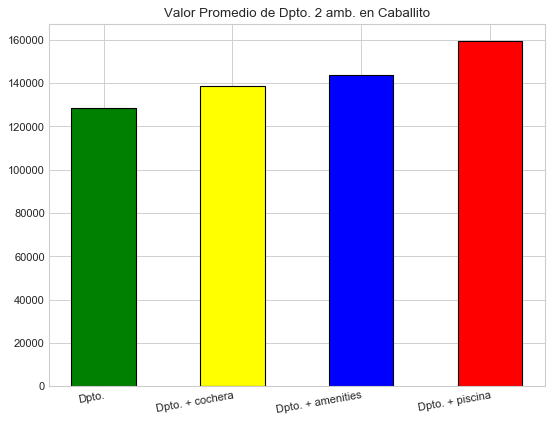

In [149]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()

names = ['Dpto.','Dpto. + cochera','Dpto. + amenities','Dpto. + piscina']

ax.bar(names[0],
       data.loc[(data.place_name == 'Caballito') & (data.rooms == 2) & (data.property_type == 'apartment'),'price_aprox_usd'].mean(), 
       color='green', 
       edgecolor='black',
       width=0.5)
ax.bar(names[1],
       data.loc[(data.place_name == 'Caballito') & (data.rooms == 2) & (data.cochera == True) & (data.property_type == 'apartment'),'price_aprox_usd'].mean(),
       color='yellow',
       edgecolor='black',
       width=0.5)
ax.bar(names[3],
        data.loc[(data.place_name == 'Caballito') & (data.rooms == 2) & (data.amenities == True) & (data.property_type == 'apartment'),'price_aprox_usd'].mean(),
       color='blue',
       edgecolor='black',
       width=0.5)
ax.bar(names[2],
       data.loc[(data.place_name == 'Caballito') & (data.rooms == 2) & (data.piscina == True) & (data.property_type == 'apartment'),'price_aprox_usd'].mean(),
       color='red',
       edgecolor='black',
       width=0.5)


ax.set_xticklabels(names,rotation=10,rotation_mode="anchor", ha="right")

ax.set(title = "Valor Promedio de Dpto. 2 amb. en Caballito")


plt.show()

### Patrón -> Metrobus

#### Metrobus en descripción

In [66]:
# Cercanía de Metrobus 

metrobus_pat = '(?<![\w\d])metrobus(?![\w\d])'
metrobus_reg = re.compile(metrobus_pat, flags = re.IGNORECASE)

In [67]:
metrobus_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else metrobus_reg.search(x))
metrobus_descripcion = metrobus_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "metrobus" en descripción:',metrobus_descripcion_macheo.notnull().sum())
print('Ejemplo:',metrobus_descripcion.iloc[266])
metrobus_descripcion.notnull().value_counts()

Macheos de "metrobus" en descripción: 1084
Ejemplo: metrobus


False    120136
True       1084
Name: description, dtype: int64

In [68]:
data.description.loc[metrobus_descripcion_macheo.notnull()].index

Int64Index([   266,    379,    558,    748,    749,    828,    840,    867,
               871,   1660,
            ...
            119636, 119715, 119883, 119896, 120007, 120010, 120791, 120794,
            121094, 121103],
           dtype='int64', length=1084)

In [69]:
data.description.iloc[871]

'Corredor Responsable: Raul Hector Merlo - CUCICBA 2407Contacto: Claudia Szakiel - MLS ID # 61110-28PH al frente con 2 dormitorios, garage, patio, lavadero e importante terraza propia. Posibilidad de construir 2 pisos más! Medidas por escritura: PB: 57,85m cub. - 16,98m semi-cub. - 15,18m descub. (PB 90,01m). Azotea: 55,04m descub. Total: 145,05m. Apto crédito.  Ubicado a 1 cuadra de Av. Chiclana, a 2 cuadras de Av. Brasil, a 2 de Av. Juan de Garay, y a 4 cuadras de Av. Boedo.  Transportes Públicos: Colectivos: 4, 6, 23, 28, 32, 75, 97, 101, 115, 128, 133, 134, 143, 165, 188 A 7 cuadras de la Estación de Subte E General Urquiza (Plaza de los Virreyes - Bolivar) y a 8 cuadras de la Estación de Subte H  Inclan (Las Heras - Hospitales) Cercanía a Metrobus y Autopista 25 de Mayo.  Te invitamos a conocerlo, te podemos ayudar!  Martillero: RAÚL HÉCTOR MERLO CUCICBA 2407 / CSI 5438   Todas las propiedades que figuran en mi perfil se encuentran a cargo del profesional matriculado de la oficina

#### Metrobus en título

In [70]:
metrobus_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else metrobus_reg.search(x))
metrobus_titulo = metrobus_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "metrobus" en título:',metrobus_titulo_macheo.notnull().sum())
print('Ejemplo:',metrobus_titulo.iloc[20936])
metrobus_titulo.notnull().value_counts()

Macheos de "metrobus" en título: 6
Ejemplo: Metrobus


False    121214
True          6
Name: title, dtype: int64

In [71]:
data.loc[metrobus_titulo_macheo.notnull()].index

Int64Index([20936, 45900, 52801, 52833, 73418, 81824], dtype='int64')

In [72]:
data.title.iloc[45900]

'2 Amb c/ balcon y cochera . Parque Lezama. Metrobus Paseo Colon. Septiembre 2017'

In [73]:
data['metrobus'] = metrobus_descripcion.notnull()

In [74]:
data['metrobus'].sum()

1084

In [75]:
data['metrobus'].loc[data['metrobus'].isnull()] = metrobus_titulo.notnull()

C:\Users\Foolface\.conda\envs\dh\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [76]:
data['metrobus'].sum()

1084

### Patrón -> Terraza

In [77]:
# Terraza

patron_terraza = '(?<![\w\d])terraza(?![\w\d])'
regex_terraza = re.compile(patron_terraza, flags = re.IGNORECASE)

#### Terrazas en Descripción

In [78]:
terraza_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else regex_terraza.search(x))
terraza_descripcion = terraza_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "terraza" en descripción:',terraza_descripcion_macheo.notnull().sum())
print('Ejemplo:',terraza_descripcion.iloc[20936])
terraza_descripcion.notnull().value_counts()

Macheos de "terraza" en descripción: 23036
Ejemplo: terraza


False    98184
True     23036
Name: description, dtype: int64

In [79]:
data.title.loc[terraza_descripcion_macheo.notnull()].index

Int64Index([    12,     13,     17,     24,     25,     28,     33,     38,
                40,     46,
            ...
            121148, 121149, 121153, 121157, 121207, 121208, 121211, 121212,
            121213, 121217],
           dtype='int64', length=23036)

In [80]:
data.description.iloc[121217]

'VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTRENAR BALCON AMENITIES.ENTREGA INMEDIATA* DEPARTAMENTO: Excelente monoambiente de (43,00m2) divisible, con Importante Placard - Baño Completo - Balcón Corrido, Cocina Integrada con Equipamiento Completo y Herrajes de Acero Inoxidable, Grifería FV, Cocina con Horno, Termotanque Eléctrico, Servicios Individuales, Preinstalación Aire Acondicionado Frío-Calor, Conexión Lavarropas y Lavavajillas.* EDIFICIO: Moderno Edificio, Amenities - Laundry - Parrillas y Solarium - Terraza de uso común - Grupo Electrógeno.* COCHERAS DISPONIBLES DESDE USD 20.000* BARRIO: Nuevo Corredor urbano de 13 manzanas - Holmberg/Donado - Área parquizada  - Bicisendas  - Zona de importantes Embajadas - Rodeado de Espacios Verdes.* MEDIOS DE TRANSPORTE: Siete cuadras del subte B - Próximo a UBA( Drago), Colegio San Patrick, estaciones Drago y Coglhan.SI TENES QUE VENDER PARA COMPRAR // SOMOS ESPECIALISTAS EN OPERACIONES SIMULTANEAS// COMUNICATE CON NOSOTROS PARA ASESORARTE.

#### Terraza en título

In [81]:
terraza_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else regex_terraza.search(x))
terraza_titulo = terraza_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "terraza" en título:',terraza_titulo_macheo.notnull().sum())
print('Ejemplo:',terraza_titulo.iloc[20936])
terraza_titulo.notnull().value_counts()

Macheos de "terraza" en título: 1796
Ejemplo: None


False    119424
True       1796
Name: title, dtype: int64

In [82]:
data.loc[terraza_titulo_macheo.notnull()].index

Int64Index([    40,     88,    160,    289,    383,    419,    427,    435,
               447,    478,
            ...
            119847, 119900, 119974, 120000, 120003, 120007, 120010, 120105,
            120123, 121153],
           dtype='int64', length=1796)

In [83]:
data.title.iloc[478]

'1 DORMITORIO Y MEDIO CON TERRAZA Y AMENITIES EN Bº GENERAL PAZ'

In [84]:
data['terraza'] = terraza_descripcion.notnull()

In [85]:
data['terraza'].sum()

23036

In [86]:
data['terraza'].loc[terraza_descripcion.isnull()] = terraza_titulo.notnull()

In [87]:
data['terraza'].sum()

23268

### Patrón -> Amenities

In [88]:
patron_amenities = '(?<![\w\d])amenities(?![\w\d])'
regex_amenities = re.compile(patron_amenities, flags = re.IGNORECASE)

#### Amenities en descripción

In [89]:
amenities_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else regex_amenities.search(x))
amenities_descripcion = amenities_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "amenities" en descripción:',amenities_descripcion_macheo.notnull().sum())
print('Ejemplo:',amenities_descripcion.iloc[40])
amenities_descripcion.notnull().value_counts()

Macheos de "amenities" en descripción: 10138
Ejemplo: AMENITIES


False    111082
True      10138
Name: description, dtype: int64

In [90]:
data.loc[amenities_descripcion_macheo.notnull()].index

Int64Index([    40,     50,     54,     55,     97,     98,    147,    148,
               209,    225,
            ...
            121198, 121199, 121200, 121201, 121202, 121203, 121204, 121205,
            121206, 121217],
           dtype='int64', length=10138)

#### Amenities en Título

In [91]:
amenities_title_macheo = data.title.apply(lambda x: x if x is np.NaN else regex_amenities.search(x))
amenities_title = amenities_title_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "amenities" en título:',amenities_title_macheo.notnull().sum())
print('Ejemplo:',amenities_title.iloc[223])
amenities_title.notnull().value_counts()

Macheos de "amenities" en título: 989
Ejemplo: Amenities


False    120231
True        989
Name: title, dtype: int64

In [92]:
data.loc[amenities_title_macheo.notnull()].index

Int64Index([   223,    385,    478,    565,    656,    869,   1223,   1374,
              1391,   1392,
            ...
            119435, 119619, 119713, 119758, 119879, 119898, 119899, 119954,
            121139, 121217],
           dtype='int64', length=989)

In [93]:
data['amenities'] = amenities_descripcion.notnull()

In [94]:
data['amenities'].sum()

10138

In [95]:
data['amenities'].loc[amenities_descripcion.isnull()] = amenities_title.notnull()

In [96]:
data['amenities'].sum()

10609

### Patrón -> Sótano

In [118]:
patron_sotano = '(?<![\w\d])sotano|sótano(?![\w\d])'
regex_sotano = re.compile(patron_sotano, flags = re.IGNORECASE)

#### Sótano en descripción

In [119]:
sotano_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else regex_sotano.search(x))
sotano_descripcion = sotano_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "sótano" en descripción:',sotano_descripcion_macheo.notnull().sum())
print('Ejemplo:',sotano_descripcion.iloc[52])
sotano_descripcion.notnull().value_counts()

Macheos de "sótano" en descripción: 813
Ejemplo: sótano


False    120407
True        813
Name: description, dtype: int64

In [120]:
data.loc[sotano_descripcion_macheo.notnull()].index

Int64Index([    52,     58,    277,    890,    913,   1024,   1371,   2722,
              3313,   3675,
            ...
            120111, 120149, 120478, 120768, 120815, 120854, 120864, 120929,
            120933, 121068],
           dtype='int64', length=813)

In [121]:
data.description.iloc[52]

'Departamento de 3 Ambientes al Contrafrente. Son 50 M2 totales. Piso 10°. El Edificio cuenta con Grupo Electrógeno. Antigüedad 50 años. Cocina 1.80 X 4.50. Lavadero 1.80 X 1.80, Living-Comedor 3 X 4.50, Dormitorio 2.80 X 3 con placard, Dormitorio 2.50 X 2.60 con placard.Baño Completo. Baulera Independiente en sótano. Expensas $1.350.-No tiene balcón. Vista abierta .NO APTO CRÉDITOExcelente ubicación, a metros del subte Linea "A" estación Primera Junta, innumerable cantidad de lineas de colectivo y en cercanías de la estación de tren Sarmiento.El inmueble se encuentra listo para escriturar y está desocupado.Ideal inversor.'

#### Sótano en título

In [122]:
sotano_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else regex_sotano.search(x))
sotano_titulo = sotano_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "amenities" en título:',sotano_titulo_macheo.notnull().sum())
print('Ejemplo:',sotano_titulo.iloc[913])
sotano_titulo.notnull().value_counts()

Macheos de "amenities" en título: 31
Ejemplo: None


False    121189
True         31
Name: title, dtype: int64

In [123]:
data.loc[sotano_titulo_macheo.notnull()].index

Int64Index([  8205,  10585,  11205,  14253,  14266,  17559,  19689,  21983,
             22062,  22524,  24186,  32241,  32883,  37950,  40119,  40396,
             40716,  46862,  48137,  53898,  54878,  56894,  58552,  60510,
             71401,  71567,  85330,  87136,  96759, 110252, 111085],
           dtype='int64')

In [124]:
data.title.iloc[8205]

'LOCAL CON SOTANO EN FLORES'

In [125]:
data['sotano'] = sotano_descripcion.notnull()

In [126]:
data['sotano'].sum()

813

In [128]:
data['sotano'].loc[sotano_descripcion.isnull()] = sotano_titulo.notnull()

In [129]:
data['sotano'].sum()

817

### Patrón -> Seguridad
#### incluye cámaras, puertas, ventanas de seguridad

In [97]:
patron_seguridad = '(?<!parasoles de )(?<![\w\d])seguridad(?![\w\d])'
regex_seguridad = re.compile(patron_seguridad, flags = re.IGNORECASE)

#### Seguridad en descripción

In [98]:
seguridad_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else regex_seguridad.search(x))
seguridad_descripcion = seguridad_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "seguridad" en descripción:',seguridad_descripcion_macheo.notnull().sum())
print('Ejemplo:',seguridad_descripcion.iloc[121205])
seguridad_descripcion.notnull().value_counts()

Macheos de "seguridad" en descripción: 11047
Ejemplo: seguridad


False    110173
True      11047
Name: description, dtype: int64

In [99]:
data.loc[seguridad_descripcion_macheo.notnull()].index

Int64Index([    24,     25,     28,     38,     40,     43,     46,     47,
                50,     68,
            ...
            121200, 121201, 121202, 121203, 121204, 121205, 121206, 121211,
            121214, 121215],
           dtype='int64', length=11047)

In [100]:
data.description.iloc[204]

'Local Comercial s/ av Callao, ubicación de alto transito y densidad de poblaciónLa propiedad cuenta con contrato vigente hasta 2018, en caso de intereses se entrega una copia del mismo para analizar la renta.Frente: 3,15 mtsFondo: 33 mtsEl local pertenece a un consorcio, con lo cual cuenta con el beneficio de la seguridad privada del mismo, 24 hs.Tiene entrada por el frente, por supuesto, (cortina metálica de enrollar) y por el hall de entrada del edificio.2 baños2 depósitosApto varios destinos con la exclusión de restautante, pescaderia y verduleria. En otras palabras no se puede habilitar cocina.El ultimo locatario logro la habilitacion como confiteria.Ideal MAXIKIOSCO / LOCUTORIOReferencias de la zona:Av Rivadavia a 2 cuadras y 1/2Av Corrientes a 2 cuadrasHotel BauenHotel SavoyCasa de la Provincia de Buenos AiresTransportes cercanos:Colectivos:5, 6, 7, 8, 12, 23, 24, 26, 37, 50, 56, 60, 64, 75, 86, 90, 98, 102, 105, 115, 124, 146, 150, 151, 180Subtes (Metro):CALLAO (Línea B), CONGR

#### Seguridad en Título

In [101]:
seguridad_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else regex_seguridad.search(x))
seguridad_titulo= seguridad_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "seguridad" en titulo:',seguridad_titulo_macheo.notnull().sum())
print('Ejemplo:',seguridad_titulo.iloc[52])
seguridad_titulo.notnull().value_counts()

Macheos de "seguridad" en titulo: 143
Ejemplo: None


False    121077
True        143
Name: title, dtype: int64

In [102]:
data.loc[seguridad_titulo_macheo.notnull()].index

Int64Index([  1576,   2660,   4674,   6131,   6132,   6478,   6815,   8292,
              8293,   8294,
            ...
            114813, 115169, 115244, 115323, 116301, 116541, 118724, 119341,
            119647, 119726],
           dtype='int64', length=143)

In [103]:
data.title.iloc[1576]

'Departamento de categoria , de 3 ambientes en suite ,piscina , seguridad , sum.'

In [104]:
data['seguridad'] = seguridad_descripcion.notnull()

In [105]:
data['seguridad'].sum()

11047

In [106]:
data['seguridad'].loc[seguridad_descripcion.isnull()] = seguridad_titulo.notnull()

In [107]:
data['seguridad'].sum()

11090

### Patrón -> Consultorio

In [141]:
patron_consultorio = '(?<!apto )(?<!apto para )(?<![\w\d])consultorio(?![\w\d])'
regex_consultorio = re.compile(patron_consultorio, flags = re.IGNORECASE)

#### Consultorio en descripción

In [142]:
consultorio_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else regex_consultorio.search(x))
consultorio_descripcion = consultorio_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "consultorio" en descripción:',consultorio_descripcion_macheo.notnull().sum())
print('Ejemplo:',consultorio_descripcion.iloc[52])
consultorio_descripcion.notnull().value_counts()

Macheos de "consultorio" en descripción: 384
Ejemplo: None


False    120836
True        384
Name: description, dtype: int64

In [143]:
data.loc[consultorio_descripcion_macheo.notnull()].index

Int64Index([   176,    527,    855,    856,    857,    858,    859,    860,
               861,    862,
            ...
            115841, 116980, 117586, 117595, 118705, 119454, 119883, 120072,
            120821, 120869],
           dtype='int64', length=384)

In [144]:
data.description.iloc[176]

'Corredor Responsable: Silvina Gallegos - Matricula N° 392Contacto: Pablo Zenker - MLS ID # 420371067-35Moderno complejo habitacional y comercial ubicado en pleno centro de Fernández Oro - JM Jorge 350-.  DEPARTAMENTO 2° A - 2 DORMITORIOS DE 82M2  Cuenta con las siguientes características:  ?     PB y dos pisos - 935M2 - ?     1 dormitorio: 4 unidades ?     2 dormitorios: 4 unidades ?     1 consultorio ?     1 local comercial  ?     Forma de pago ?     Mínimo anticipo ?     Financiación: Cuotas en pesos ajustables por CAC ?     Plazo: Hasta 24 meses  ?     Posesión: NOVIEMBRE 2017  ?     Características constructivas:   ESTRUCTURA: LA OBRA SE REALIZA CON ESTRUCTURA DE HORMIGÓN ARMADO, CON SISTEMA ANTISÍSMICO, SEGÚN REGLAMENTACIÓN VIGENTE. LA MISMA CONTARÁ DE CIMIENTOS, COLUMNAS, VIGAS Y LOSA DE ENTREPISO PORTANTE. MAMPOSTERÍAS: LOS MAMPUESTOS SE REALIZARÁN CON LADRILLO CERÁMICO HUECO DE 18 CM DE ESPESOR, EN TODO SU PERÍMETRO Y EN LOS INTERIORES SE UTILIZARA LADRILLO CERÁMICO HUECO DE 1

#### Consultorio en título

In [148]:
consultorio_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else regex_consultorio.search(x))
consultorio_titulo= consultorio_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "consultorio" en titulo:',consultorio_titulo_macheo.notnull().sum())
print('Ejemplo:',consultorio_titulo.iloc[52])
consultorio_titulo.notnull().value_counts()

Macheos de "consultorio" en titulo: 22
Ejemplo: None


False    121198
True         22
Name: title, dtype: int64

In [149]:
data.loc[consultorio_titulo_macheo.notnull()].index

Int64Index([  5749,  10923,  16545,  20904,  22012,  23286,  24049,  28108,
             33882,  33901,  42150,  42569,  50995,  58973,  63420,  64764,
             65159,  66776,  69058,  85246, 108352, 113451],
           dtype='int64')

In [150]:
data.title.iloc[5749]

'Local / Oficina / Consultorio a estrenar en Flores'

In [151]:
data['consultorio'] = consultorio_descripcion.notnull()

In [152]:
data['consultorio'].sum()

384

In [153]:
data['consultorio'].loc[consultorio_descripcion.isnull()] = consultorio_titulo.notnull()

In [154]:
data['consultorio'].sum()

388

### Patrón -> Fondo de Comercio

In [155]:
patron_fcomercio = '(?<![\w\d])fondo de comercio(?![\w\d])'
regex_fcomercio = re.compile(patron_fcomercio, flags = re.IGNORECASE)

#### Fondo de comercio en descripción

In [156]:
fcomercio_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else regex_fcomercio.search(x))
fcomercio_descripcion = fcomercio_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "fondo de comercio" en descripción:',fcomercio_descripcion_macheo.notnull().sum())
print('Ejemplo:',fcomercio_descripcion.iloc[116043])
fcomercio_descripcion.notnull().value_counts()

Macheos de "fondo de comercio" en descripción: 161
Ejemplo: Fondo de comercio


False    121059
True        161
Name: description, dtype: int64

In [157]:
data.loc[fcomercio_descripcion_macheo.notnull()].index

Int64Index([   803,    836,   1603,   1897,   2202,   2965,   2967,   3854,
              3855,   3856,
            ...
            115000, 115040, 115411, 115703, 115819, 116043, 117127, 117128,
            117230, 121073],
           dtype='int64', length=161)

In [158]:
data.description.iloc[116043]

'Fondo de comercio y alquiler comercial, Superficie total aproximada: 140 m2, Planta baja: superficie: 100 m2 (7 metros de frente aproximadamente), Planta alta: superficie 40 m2  Incluye  MOBILIARIO PLANTA BAJA: ESPACIO COMEDOR, 18 mesas, 36 sillas, Barra,1 Led de 42, Caja Registradora, Equipo de Música, ESPACIO COCINA: 1 Lomitera, 4 Hornallas, 1 Horno, 1 Heladera Baja de 5 Puertas, 1 Heladera Baja de 2 Puertas (En la Barra), 1 Horno Chico, 1 Licuadora, 1 Juguera, 1 Pica Hielo, 1 Freezer, 1 Maquina Corta Fiambres,  MOBILIARIO/ESPACIOS PLANTA ALTA: 2 Baños, 1 Deposito pequeño, 1 Sala privada / Deposito  El alquiler del local no esta incluido en el precio del fondo de comercio. El alquiler sera con impuestos incluidos. No dude en consultarnos al 3516782345 por telefono o por WhatsApp.'

#### Fondo de comercio en título

In [159]:
fcomercio_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else regex_fcomercio.search(x))
fcomercio_titulo = fcomercio_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "fondo de comercio" en título:',fcomercio_titulo_macheo.notnull().sum())
print('Ejemplo:',fcomercio_titulo.iloc[52])
fcomercio_titulo.notnull().value_counts()

Macheos de "fondo de comercio" en título: 130
Ejemplo: None


False    121090
True        130
Name: title, dtype: int64

In [160]:
data.loc[fcomercio_titulo_macheo.notnull()].index

Int64Index([   878,   1796,   1897,   2377,   2965,   2967,   3724,   3775,
              3854,   3855,
            ...
            115695, 115703, 115819, 115860, 116043, 117109, 117127, 117128,
            117230, 117740],
           dtype='int64', length=130)

In [161]:
data.title.iloc[2377]

'$ 375.000 - Fondo de Comercio en Venta - México     4300'

In [162]:
data['fondo_comercio'] = fcomercio_descripcion.notnull()

In [163]:
data['fondo_comercio'].sum()

161

In [164]:
data['fondo_comercio'].loc[fcomercio_descripcion.isnull()] = fcomercio_titulo.notnull()

In [165]:
data['fondo_comercio'].sum()

214

### Patrón -> Galería

#### Para aplicar en property_type = "stores"

In [ ]:
patron_galeria = '(?<![\w\d])galeria|galería(?![\w\d])'
regex_galeria = re.compile(patron_galeria, flags = re.IGNORECASE)

#### Galería en descripción

In [ ]:
galeria_descripcion_macheo = data.description.apply(lambda x: x if x is np.NaN else regex_galeria.search(x))
galeria_descripcion = galeria_descripcion_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "galería" en descripción:',galeria_descripcion_macheo.notnull().sum())
print('Ejemplo:',galeria_descripcion.iloc[11])
galeria_descripcion.notnull().value_counts()

In [ ]:
data.loc[galeria_descripcion_macheo.notnull()].index

In [ ]:
data.description.iloc[11]

#### Galería en título

In [ ]:
galeria_titulo_macheo = data.title.apply(lambda x: x if x is np.NaN else regex_galeria.search(x))
galeria_titulo = galeria_titulo_macheo\
        .apply(lambda x: x if x is None or x is np.NaN else x.group(0))

print('Macheos de "galería" en titulo:',galeria_titulo_macheo.notnull().sum())
print('Ejemplo:',galeria_titulo.iloc[936])
galeria_titulo.notnull().value_counts()

In [ ]:
data.loc[galeria_titulo_macheo.notnull()].index

In [ ]:
data.title.iloc[936]